<a href="https://colab.research.google.com/github/swati2000/TensorFlow/blob/master/FlowerDataset_with_transfer_learning_using_InceptionNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
#Splitting the data into training and vaidation set. 70% will be Training set and 30% will be Validation set.

(training_set, validation_set), dataset_info = tfds.load('tf_flowers', 
                                                         split = ['train[:70%]','train[70%:]'],
                                                         with_info = True,
                                                         as_supervised = True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


In [4]:
#Print Information about the Flowers Dataset

num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for i in training_set:
  num_training_examples+=1
for j in validation_set:
  num_validation_examples+=1


print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [5]:
#to know the shape, size and label of all the images in batch
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [0]:
#Reformat Images and Create Batches

IMAGE_RES = 299

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape = (IMAGE_RES,IMAGE_RES,3))

In [0]:
#Freeze the Pre-Trained Model
feature_extractor.trainable = False

In [13]:
#Attach a classification head
model = tf.keras.Sequential([feature_extractor,
                             layers.Dense(num_classes, activation='softmax')])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [14]:
#Train the model

model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])
EPOCHS = 8

history = model.fit(train_batches,
                    epochs = EPOCHS,
                    validation_data = validation_batches)

Epoch 1/8
81/81 [==============================] - 15s 187ms/step - loss: 1.2705 - accuracy: 0.6757 - val_loss: 1.1237 - val_accuracy: 0.8329
Epoch 2/8
81/81 [==============================] - 15s 181ms/step - loss: 1.0934 - accuracy: 0.8517 - val_loss: 1.0742 - val_accuracy: 0.8710
Epoch 3/8
81/81 [==============================] - 15s 184ms/step - loss: 1.0534 - accuracy: 0.8871 - val_loss: 1.0552 - val_accuracy: 0.8819
Epoch 4/8
81/81 [==============================] - 15s 182ms/step - loss: 1.0335 - accuracy: 0.8980 - val_loss: 1.0427 - val_accuracy: 0.8937
Epoch 5/8
81/81 [==============================] - 14s 179ms/step - loss: 1.0202 - accuracy: 0.9116 - val_loss: 1.0327 - val_accuracy: 0.8955
Epoch 6/8
81/81 [==============================] - 14s 178ms/step - loss: 1.0051 - accuracy: 0.9241 - val_loss: 1.0263 - val_accuracy: 0.8983
Epoch 7/8
81/81 [==============================] - 15s 180ms/step - loss: 0.9957 - accuracy: 0.9366 - val_loss: 1.0234 - val_accuracy: 0.9055
Epoch 

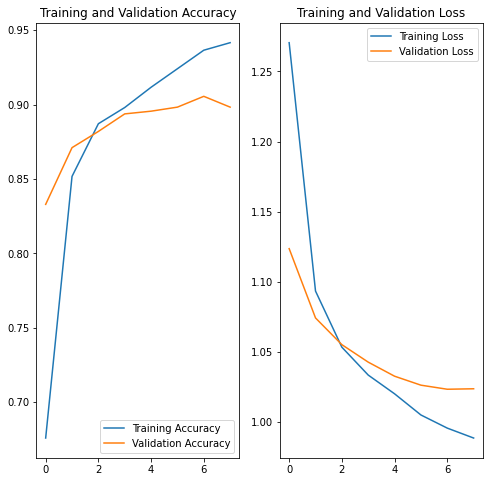

In [15]:
#Plot Training and Validation Graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
#Check Predictions
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [17]:
#Create an Image Batch and Make Predictions
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch,axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)


['dandelion' 'dandelion' 'roses' 'sunflowers' 'dandelion' 'roses'
 'sunflowers' 'sunflowers' 'tulips' 'dandelion' 'sunflowers' 'sunflowers'
 'sunflowers' 'dandelion' 'roses' 'sunflowers' 'roses' 'daisy'
 'sunflowers' 'tulips' 'tulips' 'dandelion' 'dandelion' 'dandelion'
 'sunflowers' 'tulips' 'daisy' 'sunflowers' 'daisy' 'dandelion' 'roses'
 'daisy']


In [18]:
#Print True Labels and Predicted Indices
print('Labels: ',label_batch)
print('Predicted Labels: ',predicted_ids)

Labels:  [0 0 4 3 0 4 3 3 3 0 3 2 3 0 4 3 4 1 3 2 2 3 0 0 3 2 1 3 1 0 4 1]
Predicted Labels:  [0 0 4 3 0 4 3 3 2 0 3 3 3 0 4 3 4 1 3 2 2 0 0 0 3 2 1 3 1 0 4 1]


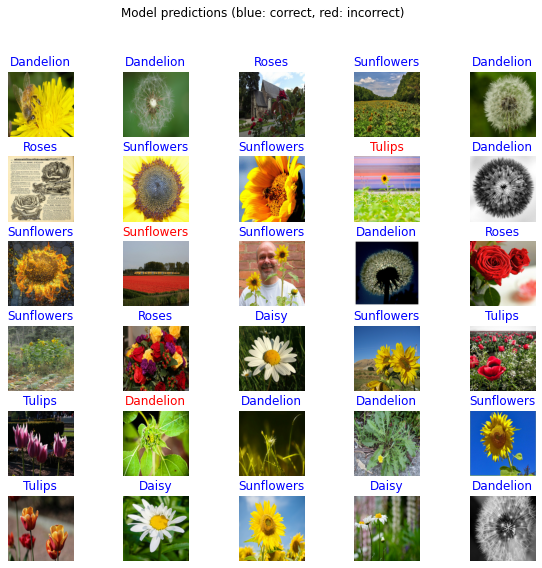

In [21]:
#Model Predictions Gaph
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")